In [9]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib import dates
import numpy as np
import sys
import xarray as xr

def correctPrecip(precip, wspd):
    '''Correct precipitation with the undercatch correction method used in 
    Yang et al. (1999) and Box et al. (2022), based on Goodison et al. (1998)
    
    Yang, D., Ishida, S., Goodison, B. E., and Gunther, T.: Bias correction of 
    daily precipitation measurements for Greenland, 
    https://doi.org/10.1029/1998jd200110, 1999.
    
    Box, J., Wehrle, A., van As, D., Fausto, R., Kjeldsen, K., Dachauer, A.,
    Ahlstrom, A. P., and Picard, G.: Greenland Ice Sheet rainfall, heat and 
    albedo feedback imapacts from the Mid-August 2021 atmospheric river, 
    Geophys. Res. Lett. 49 (11), e2021GL097356, 
    https://doi.org/10.1029/2021GL097356, 2022.
    
    Goodison, B. E., Louie, P. Y. T., and Yang, D.: Solid Precipitation 
    Measurement Intercomparison, WMO, 1998
    
    Parameters
    ----------
    precip : xarray.DataArray
        Cumulative precipitation measurements
    wspd : xarray.DataArray
        Wind speed measurements
    
    Returns
    -------
    precip_cor : xarray.DataArray
        Cumulative precipitation corrected
    precip_rate : xarray.DataArray
        Precipitation rate corrected
    '''
    # Calculate undercatch correction factor
    corr=100/(100.00-4.37*wspd+0.35*wspd*wspd)

    # Fix all values below 1.02 to 1.02
    corr = corr.where(corr>1.02, other=1.02)

    # Fill nan values in precip with preceding value                                           
    precip = precip.ffill(dim='time')   
    
    # Calculate precipitation rate
    precip_rate = precip.diff(dim='time', n=1)
    
    # Apply correction to rate
    precip_rate = precip_rate*corr
    
    # Flag rain bucket reset
    precip_rate = precip_rate.where(precip_rate>-0.01, other=np.nan) 
    b = precip_rate.to_dataframe('precip_flag').notna().to_xarray()
    
    # Get corrected cumulative precipitation, reset if rain bucket flag
    precip_cor = precip_rate.cumsum()-precip_rate.cumsum().where(~b['precip_flag']).ffill(dim='time').fillna(0).astype(float)
       
    return precip_cor, precip_rate

data_dir = '../../data'


In [12]:
# =============================================================================
# Import all data and fix timestamps to match each other
# =============================================================================

cosipy_data = xr.open_dataset(r'%s/KANL_cosipy_output_20090101-20221229_v3.nc' % data_dir, engine='netcdf4')
mask1 = (cosipy_data['time'] >= pd.to_datetime('2022-08-15')) & (cosipy_data['time'] <= pd.to_datetime('2022-09-30')) # 2022-09-01 to 2022-09-30

#### melt event 1 #################
surfm = cosipy_data['surfM'].loc[mask1]
surfm = surfm.mean(dim=['lon', 'lat']).resample(time='24H').sum('time', skipna=True)

T2 = cosipy_data['T2'].loc[mask1]
T2 = T2.mean(dim=['lon', 'lat']).resample(time='3H').mean('time', skipna=True).values - 273.15
RAIN = cosipy_data['RRR'].loc[mask1]
RAIN = RAIN.mean(dim=['lon', 'lat']).resample(time='1D').sum('time').values / 1000 # CONVERT TO MW.E.

SW_in = cosipy_data['G'].loc[mask1].mean(dim=['lon', 'lat']).resample(time='3H').mean('time', skipna=True)
SW_net = SW_in * (1-0.57)
LW_net = cosipy_data['LWin'].loc[mask1].mean(dim=['lon', 'lat']).resample(time='3H').mean('time', skipna=True).values + cosipy_data['LWout'].loc[mask1].mean(dim=['lon', 'lat']).resample(time='3H').mean('time', skipna=True).values
H = cosipy_data['H'].loc[mask1].mean(dim=['lon', 'lat']).resample(time='3H').mean('time', skipna=True).values #SENSIBLE
LE = cosipy_data['LE'].loc[mask1].mean(dim=['lon', 'lat']).resample(time='3H').mean('time', skipna=True).values #LATENT
B = cosipy_data['B'].loc[mask1].mean(dim=['lon', 'lat']).resample(time='3H').mean('time', skipna=True).values #GROUND
QRR = cosipy_data['QRR'].loc[mask1].mean(dim=['lon', 'lat']).resample(time='3H').mean('time', skipna=True).values #RAIN
ME = cosipy_data['ME'].loc[mask1].mean(dim=['lon', 'lat']).resample(time='3H').mean('time', skipna=True).values #MELT ENERGY
SW_net = ME - LW_net - H - LE - B - QRR

SW_in['time'] = pd.to_datetime(SW_in['time'].values).strftime('%d/%m %Hh')
time = SW_in['time'].values 
time = list(map(str, time))

time_ticks = time[0::8]
time_ticks = list(map(str, time_ticks))

time_tick_labels1 = list(map(str, np.arange(15, 32, 1)))
time_tick_labels = [i.zfill(2) for i in time_tick_labels1]

time_tick_labels2 = list(map(str, np.arange(1, 31, 1)))
time_tick_labels2 = [i.zfill(2) for i in time_tick_labels2]

time_tick_labels = time_tick_labels + time_tick_labels2


surfM_historic_raw =  cosipy_data['surfM'].mean(dim=['lon', 'lat']) # average spatially
surfM_historic_raw = surfM_historic_raw.resample(time='1D').sum('time') # sum total daily melt
surfM_historic = surfM_historic_raw.to_dataframe() # convert to pandas dataframe

surfM_historic = surfM_historic.groupby([surfM_historic.index.day, surfM_historic.index.month], as_index=False, sort=False).mean() # calculate yearly daily average
surfM_historic = surfM_historic.drop(0)
surfM_historic.index = pd.date_range(start='01-01-2022', end='12-31-2022', freq='1D')



In [13]:
KANB_data = pd.read_csv('%s/met_data/KAN_B_hour_2022.csv' % data_dir)
KANB_data.time = pd.to_datetime(KANB_data.time, dayfirst=True)

precip = xr.DataArray(data=KANB_data['precip_u'], dims=['time'], coords=dict(time=KANB_data.time.values), name=['precip'])
wspd = xr.DataArray(data=KANB_data['wspd_u'], dims=['time'], coords=dict(time=KANB_data.time.values), name=['wspd'])
precip_cor, precip_rate = correctPrecip(precip, wspd)

precip_daily = precip_rate.resample(time='1D').sum('time')
precip_daily = precip_daily.resample(time='H').ffill()

# mask = (precip_cor['time'] >= pd.to_datetime('2022-09-20')) & (precip_cor['time'] <= pd.to_datetime('2022-09-23')) 
# precip_rate = precip_rate.loc[mask]
# precip_rate.plot()

In [14]:
df = pd.DataFrame(index=time, 
                  data={'Longwave net': LW_net, 
                        'Shortwave net' : SW_net,
                        'Sensible Heat Flux': H, 
                        'Latent Heat Flux': LE, 
                        'Ground Heat Flux': B,
                        'Rain Heat Flux' : QRR})

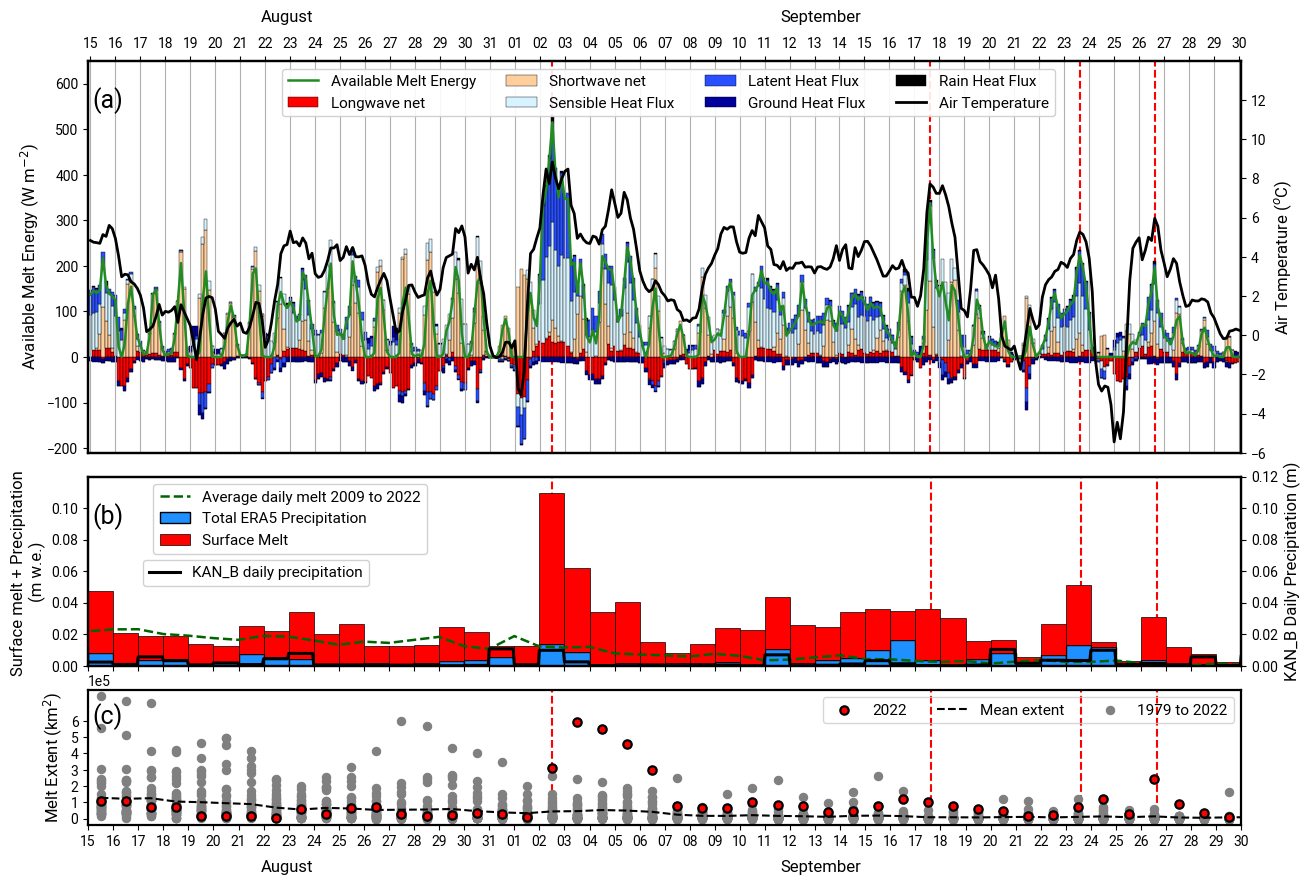

In [15]:
extent_area = pd.read_csv(data_dir + '/met_data/August-September_melt_extent_Mote-et-al-2018.csv')
extent_area = extent_area.drop('day', axis=1)
mean_extent = extent_area.mean(axis=1)

#-----------------------figure user options------------------------------------
tick_fontsize = 10
label_fontsize = 12
title_fontsize = 12
mpl.rcParams['font.family'] = 'Roboto' #'Helvetica'
plt.rcParams['axes.linewidth'] = 1.6
plt.rc('xtick', labelsize=tick_fontsize)
plt.rc('ytick', labelsize=tick_fontsize)
plt.rc('axes', labelsize=label_fontsize)
plt.rc('axes', titlesize=title_fontsize)
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('figure', titlesize=title_fontsize)  # fontsize of the figure title
plt.rcParams['axes.facecolor'] = 'None'

width = 6.88 + 8
height = width/1.5

# =============================================================================
#  Creating big graph figure
# =============================================================================
fig = plt.figure()
spec = gridspec.GridSpec(ncols=1, nrows=3, height_ratios=(2.9,1.4,1), hspace=0.1)

#----------ax1----temperature and SWin-----------------------------------------
ax1 = fig.add_subplot(spec[0])

df.plot(kind="bar", stacked=True, width=1, edgecolor='k', linewidth=0.3, colormap='flag', ax=ax1, rot=0, use_index=True, legend=False)
ax1.plot(time, ME, color='forestgreen', linestyle='-', linewidth=1.8, label='Available Melt Energy')
ax1.set_ylabel('Available Melt Energy (W m$^{-2}$)')
ax1.set_ylim(-210, 650)

ax1.set_xticks(time_ticks)
ax1.set_xticklabels(time_tick_labels)
ax1.grid(axis='x')
ax1.xaxis.tick_top()

ax1b = ax1.twinx()
lns2 = ax1b.plot(time, T2, color='k', linestyle='-', linewidth=2,  label='Air Temperature')
ax1b.set_ylabel('Air Temperature ($^{o}$C)')
ax1b.set_yticks([-6,-4, -2, 0, 2, 4, 6, 8, 10, 12])
ax1b.set_ylim(-6,14)

ax1.text(0.004, 0.88, '(a)', transform=ax1.transAxes, fontsize=18)
ax1.text(0.15, 1.1, 'August', transform=ax1.transAxes, fontsize=12)
ax1.text(0.6, 1.1, 'September', transform=ax1.transAxes, fontsize=12)

ax1.axvline('02/09 12h', color='r', linewidth=1.5, linestyle='--', zorder=-5)
ax1.axvline('17/09 15h', color='r', linewidth=1.5, linestyle='--', zorder=-5)
ax1.axvline('23/09 15h', color='r', linewidth=1.5, linestyle='--', zorder=-5)
ax1.axvline('26/09 15h', color='r', linewidth=1.5, linestyle='--', zorder=-5)


fig.legend(ncol=4, framealpha=0.9, facecolor='white', loc='upper left', bbox_to_anchor=(0.25, 0.88))

##########################################################################################################################
time_lims = surfm['time'] 
time_rain_surfm = surfm['time'] + pd.Timedelta('0.5 day')
time_rain_KANB = precip_daily['time'] + pd.Timedelta('0.5 day')

ax2 = fig.add_subplot(spec[1])

ax2.bar(time_rain_surfm, RAIN, edgecolor='k', width=pd.Timedelta('1 day'), color='dodgerblue', label='Total ERA5 Precipitation')
ax2.bar(time_rain_surfm, surfm, bottom=RAIN, edgecolor='k', width=pd.Timedelta('1 day'), color='red', linewidth=0.5, label='Surface Melt')
ax2.plot(surfM_historic.index, surfM_historic, color='darkgreen', linewidth=1.8, linestyle='--', zorder=3, label='Average daily melt 2009 to 2022')
#ax2.axhline(y=0.037)

ax2.axvline(pd.to_datetime('2022-09-02 12:00'), color='r', linewidth=1.5, linestyle='--', zorder=-5)
ax2.axvline(pd.to_datetime('2022-09-17 15:00'), color='r', linewidth=1.5, linestyle='--', zorder=-5)
ax2.axvline(pd.to_datetime('2022-09-23 15:00'), color='r', linewidth=1.5, linestyle='--', zorder=-5)
ax2.axvline(pd.to_datetime('2022-09-26 15:00'), color='r', linewidth=1.5, linestyle='--', zorder=-5)


ax2.text(0.004, 0.75, '(b)', transform=ax2.transAxes, fontsize=18)
ax2.set_ylabel('Surface melt + Precipitation \n(m w.e.)')
ax2.set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.1])
ax2.legend(loc='upper left', ncol=1, framealpha=0.9, bbox_to_anchor=(0.05, 1))
ax2.set_xticklabels([], color='w')

ax2.set_xlim(time_lims[0], time_lims[-1])
ax2.set_ylim(0,0.12)

myFmt = mdates.DateFormatter('%d')
ax2.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))

ax2c = ax2.twinx()
ax2c.set_ylim(0,0.12)
ax2c.plot(precip_daily.time, precip_daily/1000, color='k',linewidth=2.2, label='KAN_B daily precipitation')
ax2c.set_ylabel('KAN_B Daily Precipitation (m)', color='k')
ax2c.legend(bbox_to_anchor=(0.25,0.6), framealpha=0.9)


###################################################################################################
ax3 = fig.add_subplot(spec[2])

ax3.scatter(time_rain_surfm, extent_area['2022'][14:], color='red', edgecolor='k', linewidth=1.6, label='2022')
ax3.plot(time_rain_surfm, mean_extent[14:], color='k', linestyle='--', zorder=-1, label='Mean extent')

for col in extent_area.columns:
    if not col=='day' or not col=='2019':
        ax3.scatter(time_rain_surfm, extent_area[col][14:], color='grey', zorder=-2, linewidth=0.8)
    if col=='2019':
        ax3.scatter(time_rain_surfm, extent_area[col][14:], color='grey', zorder=-2, linewidth=0.8, label='1979 to 2022')

ax3.set_xlim(time_lims[0], time_lims[-1])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax3.set_ylabel('Melt Extent (km$^{2}$)')
ax3.set_yticks([0, 100000, 200000, 300000, 400000, 500000, 600000])

myFmt = mdates.DateFormatter('%d')
ax3.xaxis.set_major_formatter(myFmt)
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax3.text(0.15, -0.35, 'August', transform=ax3.transAxes, fontsize=12)
ax3.text(0.6, -0.35, 'September', transform=ax3.transAxes, fontsize=12)

ax3.axvline(pd.to_datetime('2022-09-02 12:00'), color='r', linewidth=1.5, linestyle='--', zorder=-5)
ax3.axvline(pd.to_datetime('2022-09-17 15:00'), color='r', linewidth=1.5, linestyle='--', zorder=-5)
ax3.axvline(pd.to_datetime('2022-09-23 15:00'), color='r', linewidth=1.5, linestyle='--', zorder=-5)
ax3.axvline(pd.to_datetime('2022-09-26 15:00'), color='r', linewidth=1.5, linestyle='--', zorder=-5)

ax3.legend(loc='best', ncol=3)#, bbox_to_anchor=(2.8, 1.25))
ax3.text(0.004, 0.75, '(c)', transform=ax3.transAxes, fontsize=18)

fig.set_size_inches(width, height)
fig.savefig('fig2_met-overview.jpg', dpi=300)
plt.show()
